## Importing Packages Needed

In [58]:
import numpy as np
import matplotlib.pyplot as py
from scipy.optimize import curve_fit
import collections as col
import statistics
from scipy.interpolate import UnivariateSpline

## Definition of Named Tuples

In [59]:
component = col.namedtuple('component','phase intensity')
ind_component = col.namedtuple('component','phase intensity width')
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2 errors')
component_separation = col.namedtuple('component_separation','frequency separation')

# Definition of Functions

Gaussian Fitting Functions:

In [60]:
def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))\

def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

In [61]:
"""
    Used to get the parameters, covariance matrix and errors for any number of gaussian fits, through and expected value. 
"""
def fitting_parameters(x,y,expected,bound):
    """
    bound=([],[])
    for i in range(len(expected)):
        bound[0].append(0)
        bound[1].append(np.inf)
    """
        
    params,cov=curve_fit(multi_gauss,x,y,expected, bounds=bound)
    sigma=np.sqrt(np.diag(cov))
    return params, cov, sigma

Chi Squared functions

In [62]:
"""
    Compute the data's chi squared values.

    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float/list
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
"""
def chsq(observed_values, expected_values, err):
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

Error Finding Functions

In [63]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.
    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

In [64]:
def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [65]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = sqrt.J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian

    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

Finding Peak of Fittings Function

In [66]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all peaks of a gaussian function, where the derivative is equal to zero. 

    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
            
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)
    
    return minima, maxima, minima_e, maxima_e

In [67]:
def gauss_peaks(fit, nofreqband, freqband, pcov, params, freq_low, freq_high, noise, data = 'parkes', freq=0):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    pcov: list
        the covariance matrix from the fit
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    minima, peakpos, minima_e, err = find_minima_maxima_gauss(params, pcov, len(fit))
    peakint = multi_gauss(peakpos, *params)
    
    """
    #Removes peaks until only two highest remain - which also have to be the two outer peaks
    #If the highest do not correspond to the outer, the frequency band is not used
    while len(peakpos)>2:
        mn=min(peakint)
        peakint = list(peakint)
        rm = peakint.index(mn)
        if rm!=0 and rm!=len(peakpos)-1:
            del peakpos[rm]
            del peakint[rm]
            del err[rm]
        else:
            break 
    """

    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    
    component1=0
    component2=0
    errr=[]
    
    if(max(peakint)/noise)>3:
        if data=='parkes':
            for n,p in enumerate(peakpos):
                if p>670 and p<710:
                    component1 = component(phase=(deg_mod)*peakpos[n], intensity=peakint[n])
                    errr.append(err[n])
                elif p>720:
                    component2 = component(phase=(deg_mod)*peakpos[n], intensity=peakint[n])
                    errr.append(err[n])
        elif data!='parkes' and len(peakpos)==2:
            component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
            errr.append(err[0])
            component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
            errr.append(err[1])
    else:
        print("Too noisey", freqband)
                
    if component1==0 or component2==0:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0   
        print("peaks",len(peakpos),peakpos,"band", freqband)
    else:
        error = np.array(errr)*(deg_mod)
        
    """
    if len(peakpos)==2 and (max(peakint)/noise)>3:
        component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
        component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        error = np.array(err)*(deg_mod)
    elif len(peakpos)==3 and (max(peakint)/noise)>3:
        component1 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        component2 = component(phase=(deg_mod)*peakpos[2], intensity=peakint[2])
        error = np.array(err)*(deg_mod)        
    elif len(peakpos)==4 and (max(peakint)/noise)>3:
        component1 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        component2 = component(phase=(deg_mod)*peakpos[3], intensity=peakint[3])
        error = np.array(err)*(deg_mod)   
    else:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0       
   """
   
    #Converts the frequency from bins to MHz    
    if data=='parkes':
        freq=(((freq_high-freq_low)/nofreqband)*(freqband))+freq_low+((freq_high-freq_low)/(nofreqband*2))
    else:
        freq=freq[freqband]

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

In [68]:
def fit_peaks(fit, freqband, pcov, params, noise, frequency):
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    peakpos = params[1]
    paramint = params[0]
    errcov = np.sqrt(np.diag(pcov))
    err = errcov[1]
    if len(params)>3:
        peakpos=np.append(peakpos,params[4])
        paramint=np.append(paramint,params[3])
        err = np.append(err,errcov[4])
    if len(params)>6:
        peakpos=np.append(peakpos,params[7])
        paramint=np.append(paramint,params[6])
        err=np.append(err,errcov[7])

    print(peakpos)
    peakint = multi_gauss(peakpos, *params)
    print(peakint)

    #Removes peaks until only two highest remain - which also have to be the two outer peaks
    #If the highest do not correspond to the outer, the frequency band is not used
    while len(peakpos)>2:
        mn=min(paramint)
        paramint = list(paramint)
        rm = paramint.index(mn)   
        print(rm)
        peakpos=np.delete(peakpos,rm)
        peakint=np.delete(peakint,rm)
        err=np.delete(err,rm)

    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    
    component1=0
    component2=0
    errr=[]
    
    if(max(peakint)/noise)>3:
        if len(peakpos)==2:
            component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
            errr.append(err[0])
            component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
            errr.append(err[1])
    else:
        print("Too noisey", freqband)
                
    if component1==0 or component2==0:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0   
        print("peaks",len(peakpos),peakpos,"band", freqband)
    else:
        error = np.array(errr)*(deg_mod)

    #Converts the frequency from bins to MHz    
    freq=frequency[freqband]
    
    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

In [69]:
"""
    Graphing Sub-pulse operation:
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_comp(fit_comp,comp_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        for i in range(0,len(fit_comp)):
            if fit_comp[i][comp_num][0]!=0:
                phase_comp.append(fit_comp[i][comp_num][0])
                frequency_comp.append(fit_comp[i][0])
                comp_err.append(fit_comp[i][3][comp_num-1])

        return phase_comp, frequency_comp, comp_err    

Removing outliers

In [70]:
"""
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors (greater than 100 degrees).
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    #Find mean and standard deviation of data
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    for i in range(len(phase_comp)):
        #Find z score
        z_score= (phase_comp[i] - mean_1)/std_1 
        #Only include points which have a z score under the threshold value, and with errors less than 100 degrees
        if np.abs(z_score) < threshold and comp_err[i]<20:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

Plotting Fittings Functions

In [71]:
"""
    Plotting functions to plot the gaussian fit, three gaussian fit with the gaussians filled in,
    and the peaks of the gaussian fit. 
"""
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=1, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

def plot_fill(x,y,params):
    params1 = params[0:3]
    gfit1 = gauss(x, *params1)
    params2 = params[3:6]
    gfit2 = gauss(x, *params2)
    if len(params)>6:
        params3 = params[6:9]
        gfit3 = gauss(x, *params3)
    if len(params)>9:
        params4 = params[9:12]
        gfit4 = gauss(x, *params4)
    
    py.plot(x, y, lw=1, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
    if len(params)>6:
        py.plot(x, gfit3, "r")
        py.fill_between(x, gfit3.min(), gfit3, facecolor="red", alpha=0.5)
    if len(params)>9:
        py.plot(x, gfit4, "b")
        py.fill_between(x, gfit4.min(), gfit4, facecolor="blue", alpha=0.5)
    return 

def plot_peaks(x,y,profile_comp):
    py.plot(x,y, lw=1)
    py.plot(x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Separation Data

In [72]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))
def linear(x, m, c):
    return ((m * np.array(x)) + c)

In [73]:
"""
    Used to gain separation of components values and the uncertainties. 
"""
def separation_singleprofile(components_array):
    sep_array=[]
    uncert=[]

    #Go through all the different frequencies
    for i in range(0,len(components_array)):
        if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
            freq=components_array[i][0]
            #Subtract second component from first
            sep=(components_array[i][2][0]) - (components_array[i][1][0])
            single_sep=component_separation(frequency=freq, separation=sep)
            sep_array.append(single_sep)
            #Calculate uncertainty
            uncert.append(np.sqrt((components_array[i][3][0])**2 + (components_array[i][3][1])**2))
    return sep_array, uncert

# Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

#### Parkes Data Set

In [74]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [75]:
#averageprofiles = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/Parkes_archive_files/B1944-2600s-T-f32-pazi.pdv', dtype=fulldatatype)
averageprofiles = np.loadtxt(fname='../Parkes_archive_files/4500nsub/B1944-Tp.paz.pdv', dtype=fulldatatype)
maxf=4000
minf=700
no_freq_bands = max(averageprofiles['frequency']) + 1
size_freq = (maxf-minf) / no_freq_bands
halfsize_freq = size_freq / 2

#### EPN Profiles

In [76]:
bkk = np.loadtxt(fname='../EPN_files/B1944-129.4-LOFAR-bkk.txt', dtype=fulldatatype)
bkk2 = np.loadtxt(fname='../EPN_files/B1944-168.4-LOFAR-bkk.txt', dtype=fulldatatype)
bkk2['frequency']=1
bkk=np.append(bkk,bkk2)
bkk_phase = max(bkk['phase']) + 1
bkk_freq = [129.4,168.4]

In [77]:
ant = np.loadtxt(fname='../EPN_files/B1944-400-gb-ant94.txt', dtype=fulldatatype)
ant2 = np.loadtxt(fname='../EPN_files/B1944-800-gb-ant94.txt', dtype=fulldatatype)
ant3 = np.loadtxt(fname='../EPN_files/B1944-1330-gb-ant94.txt', dtype=fulldatatype)
ant4 = np.loadtxt(fname='../EPN_files/B1944-1640-gb-ant94.txt', dtype=fulldatatype)
ant2['frequency']=1
ant3['frequency']=2
ant4['frequency']=3
ant=np.append(ant,ant2)
ant=np.append(ant,ant3)
ant=np.append(ant,ant4)
ant_phase = max(ant['phase']) + 1
ant_freq = [400,800,1330,1640]

In [78]:
gl = np.loadtxt(fname='../EPN_files/B1944-410-Lovell-gl98.txt', dtype=fulldatatype)
gl2 = np.loadtxt(fname='../EPN_files/B1944-610-Lovell-gl98.txt', dtype=fulldatatype)
gl3 = np.loadtxt(fname='../EPN_files/B1944-925-Lovell-gl98.txt', dtype=fulldatatype)
gl4 = np.loadtxt(fname='../EPN_files/B1944-1408-Lovell-gl98.txt', dtype=fulldatatype)
gl2['frequency']=1
gl3['frequency']=2
gl4['frequency']=3
gl=np.append(gl,gl2)
gl=np.append(gl,gl3)
gl=np.append(gl,gl4)
gl_phase = max(gl['phase']) + 1
gl_freq = [410,610,925,1408]

In [79]:
j = np.loadtxt(fname='../EPN_files/B1944-673.9-Parkes-j98.txt', dtype=fulldatatype)
j_phase = max(j['phase']) + 1
j_freq = [673.9]

In [80]:
wc =np.loadtxt(fname='../EPN_files/B1944-1418-Arecibo-wc.txt', dtype=fulldatatype)
wc_phase = max(wc['phase']) + 1
wc_freq = [1418]

In [81]:
sgg = np.loadtxt(fname='../EPN_files/B1944-1420-Effelsberg-sgg.txt', dtype=fulldatatype)
sgg2 = np.loadtxt(fname='../EPN_files/B1944-4750-Effelsberg-sgg.txt', dtype=fulldatatype)
sgg2['frequency']=1
sgg=np.append(sgg,sgg2)
sgg_phase = max(sgg['phase']) + 1
sgg_freq = [1420,4750]

In [82]:
hkk = np.loadtxt(fname='../EPN_files/B1944-4850-Effelsberg-hkk.txt', dtype=fulldatatype)
hkk_phase = max(hkk['phase']) + 1
hkk_freq = [4850]

# INDIVIDUAL FREQUENCY BAND

Following Section is for error checking. It displays how each frequency band is fitted and it's peaks. 

#### Parkes Data Set

In [83]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 28

f = averageprofiles['frequency'] == freqband
x=averageprofiles['phase'][f]
y=averageprofiles['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(0.15,660,6,0.55,695,20,0.1,715,10,0.25,740,8)
bounds1=([0,635,0,0,675,0,0,712,0,0,720,0],[np.inf,685,np.inf,np.inf,725,np.inf,np.inf,740,np.inf,np.inf,770,np.inf])
#expected2=(0.1,660,6,0.75,690,20,0.2,710,10,0.25,740,15)

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error)

#py.axis([200,400,-0.05,0.07])

[600, 825, -0.1, 2.8]

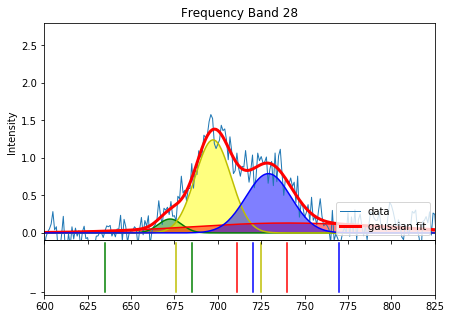

In [84]:
#Plot fill parameters
params1 = params[0:3]
params2 = params[3:6]
params3 = params[6:9]
params4 = params[9:12]
gfit1 = gauss(x, *params1)
gfit2 = gauss(x, *params2)
gfit3 = gauss(x, *params3)
gfit4 = gauss(x, *params4)
#Boundary parameters
yt=[0,1]
x1=[635,635]
x2=[685,685]
x3=[676,676]
x4=[725,725]
x5=[711,711]
x6=[740,740]
x7=[720,720]
x8=[770,770]

    
plot = py.figure(figsize=(7, 5))
grid = py.GridSpec(5, 1, hspace=0, wspace=0)
boundary = plot.add_subplot(grid[4, 0])
main_ax = plot.add_subplot(grid[0:4, 0], sharex=boundary)


main_ax.plot(x, y, lw=1, label='data')
main_ax.plot(x,fit,color='red',lw=3,label='gaussian fit')
main_ax.plot(x, gfit1, "g")
main_ax.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
main_ax.plot(x, gfit2, "y")
main_ax.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
main_ax.plot(x, gfit3, "r")
main_ax.fill_between(x, gfit3.min(), gfit3, facecolor="red", alpha=0.5)
main_ax.plot(x, gfit4, "b")
main_ax.fill_between(x, gfit4.min(), gfit4, facecolor="blue", alpha=0.5)
boundary.plot(x1,yt, "g", '--')
boundary.plot(x2,yt, "g", '--')
boundary.plot(x3,yt, "y", '--')
boundary.plot(x4,yt, "y", '--')
boundary.plot(x5,yt, "r", '--')
boundary.plot(x6,yt, "r", '--')
boundary.plot(x7,yt, "b", '--')
boundary.plot(x8,yt, "b", '--')

py.title("Frequency Band 28")

py.ylabel('Intensity')
py.xlabel('Frequency (Bins)')
main_ax.legend(loc='lower right')
boundary.label_outer()
main_ax.label_outer()
py.axis([600,825,-0.1,2.8])

[210.9375, 298.828125, -0.1, 2.8]

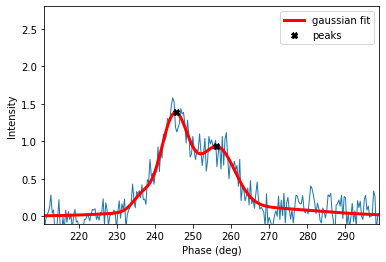

In [85]:
plot_peaks(x*(360/1024),y,profile_comp)
py.axis([210.9375,298.828125,-0.1,2.8])

#### EPN Profiles

In [86]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = j['frequency'] == freqband
x=j['phase'][f]
y=j['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(1,55,3,0.5,60,3)
bounds1=([0,0,0,0,0,0],[np.inf,j_phase,np.inf,np.inf,j_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
j_comp = fit_peaks(fit, freqband, cov, params,error,j_freq)
j_components = [j_comp]

[56.02017022 60.86188052]
[0.9860197  0.51831046]


In [87]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = wc['frequency'] == freqband
x=wc['phase'][f]
y=wc['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(0.1,470,10,0.6,505,3,0.4,550,3)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,wc_phase,np.inf,np.inf,wc_phase,np.inf,np.inf,wc_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
wc_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',wc_freq)
wc_components = [wc_comp]

In [88]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = sgg['frequency'] == freqband
x=sgg['phase'][f]
y=sgg['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(40,225,10,100,400,5,60,550,3)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,sgg_phase,np.inf,np.inf,sgg_phase,np.inf,np.inf,sgg_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
sgg1_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',sgg_freq)

C:\Users\Lisas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Lisas\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars


In [89]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 1

f = sgg['frequency'] == freqband
x=sgg['phase'][f]
y=sgg['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(100,170,5,100,270,3)
bounds1=([0,0,0,0,0,0],[np.inf,sgg_phase,np.inf,np.inf,sgg_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
sgg2_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',sgg_freq)
sgg_components = [sgg1_comp,sgg2_comp]

In [90]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = hkk['frequency'] == freqband
x=hkk['phase'][f]
y=hkk['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(0.8,87,5,0.8,100,3)
bounds1=([0,0,0,0,0,0],[np.inf,hkk_phase,np.inf,np.inf,hkk_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
hkk_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',hkk_freq)
hkk_components = [hkk_comp]

[ 0.81358543 89.02017639  4.21280163  0.73601453 98.95715693  2.57399603]


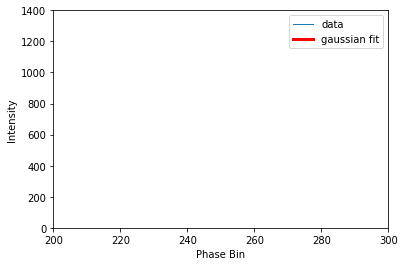

In [91]:
plot_fill(x,y,params)
py.axis([200,300,0,1400])
#py.axis([400,600,0,0.600])
#py.axis([60,120,0,0.9])
print(params)

pulse_component(frequency=728.2602163461538, comp1=component(phase=245.4349618420614, intensity=1.3852285596493765), comp2=component(phase=256.08401069662716, intensity=0.932068836815219), errors=array([0.24555204, 0.60566305]))


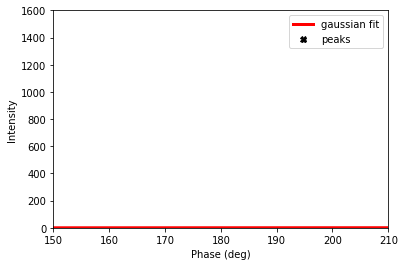

In [92]:
plot_peaks(x*(360/len(x)),y,profile_comp)
py.axis([150,210,0,1600])
print(profile_comp)

# ALL FREQUENCY BANDS

# Gaussian Plotting and Finding Peaks of Overall Fit


The following is a looped version of the previous section to find the correct peaks for each pulse profile

#### Parkes Data

In [93]:
fit_components = []
#Taken from Peaks and Gaussian fittings of frequency band 6, in the middle
#expected=(0.1,660,6,0.75,695,20,0.2,720,10,0.25,750,15)
expected1=(0.15,660,6,0.55,695,20,0.1,715,10,0.25,740,8)
bounds1=([0,625,0,0,675,0,0,712,0,0,720,0],[np.inf,675,np.inf,np.inf,725,np.inf,np.inf,740,np.inf,np.inf,760,np.inf])


#Loop thought all of the frequency bands
for i in range(0,no_freq_bands):
    freqband = i
    f = averageprofiles['frequency'] == freqband
    x=averageprofiles['phase'][f]
    y=averageprofiles['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params, minf,maxf,error)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        fit_components.append(profile_comp)

C:\Users\Lisas\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Lisas\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


peaks 1 [695.1913312850264] band 13
peaks 1 [697.4406730115666] band 17
Too noisey 19
peaks 2 [695.7652358779598, 724.0077860837937] band 19


C:\Users\Lisas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Too noisey 27
peaks 3 [696.8792029094042, 724.1849050616044, 745.2761796201639] band 27
peaks 2 [665.3708119953143, 699.9868891321269] band 40
peaks 2 [663.507214343932, 700.3354097418132] band 41
peaks 2 [665.6965753686832, 699.1586426288654] band 42
peaks 2 [665.1886946064768, 698.8197716684549] band 43
peaks 2 [671.7547039216021, 698.6113859730928] band 46
peaks 1 [699.4109401660568] band 48
peaks 2 [669.677055090099, 698.0181941374927] band 49
Too noisey 84
peaks 3 [630.441634697881, 694.1661176644718, 712.9732530264413] band 84
Too noisey 91
peaks 3 [654.7655464493998, 693.945521973762, 739.494894510474] band 91
peaks 3 [656.2644415340553, 693.3764553211321, 714.5832224169227] band 92
Too noisey 93
peaks 4 [654.9246895102866, 696.7278221686436, 716.0217534343204, 759.9999999357915] band 93
Too noisey 100
peaks 4 [654.7757357184915, 699.325690998029, 713.9765960184393, 753.5240270226722] band 100
peaks 2 [665.1261997236433, 696.3174293233196] band 102
peaks 2 [666.1475940362137, 69

Too noisey 365
peaks 3 [676.5986482890687, 711.7977098999637, 753.7361668794476] band 365
Too noisey 366
peaks 3 [684.0209749028147, 713.4583552927052, 750.7207695146647] band 366
Too noisey 367
peaks 4 [661.876370591833, 686.0767684650726, 710.0697622496366, 749.5545454844146] band 367
Too noisey 371
peaks 3 [675.9373021792513, 711.6945695098705, 759.8856738578361] band 371
Too noisey 372
peaks 4 [664.2549310091762, 685.7160020836652, 713.2335642405194, 753.7821496638396] band 372
Too noisey 373
peaks 3 [690.9229001311793, 714.9915205437884, 744.9742817036024] band 373
Too noisey 374
peaks 3 [680.7696362311509, 711.9042793896264, 759.87508629056] band 374
Too noisey 375
peaks 3 [675.620872632969, 711.5381457199117, 743.0869078665905] band 375
Too noisey 401
peaks 2 [687.3509578913358, 716.4512371070533] band 401
peaks 3 [665.8195526751371, 684.3384509401467, 710.8203502955537] band 402
Too noisey 403
peaks 2 [684.098800124422, 718.8517550516111] band 403
Too noisey 404
peaks 4 [670.43

Too noisey 514
peaks 4 [627.0228669995621, 700.4267188315919, 729.7166280502148, 739.9929494003015] band 514
Too noisey 515
peaks 3 [691.0549412612143, 709.3044079608557, 739.0133088149033] band 515
Too noisey 516
peaks 4 [660.1309788216913, 698.4981280827313, 739.7303381866843, 744.2851576159671] band 516
peaks 2 [702.023805606885, 713.7144823537069] band 517
peaks 2 [710.525961610667, 741.9010720373531] band 518
Too noisey 520
peaks 3 [662.7091278861474, 703.3748540161174, 738.0171574000924] band 520
Too noisey 521
peaks 4 [666.5333074620061, 695.7395602773595, 711.2991277618837, 738.5109377322943] band 521
Too noisey 522
peaks 3 [666.2048385489558, 710.7268677609658, 743.6012810590807] band 522
Too noisey 523
peaks 4 [625.0000897950842, 697.7482277438043, 711.5223859180288, 740.9841905880186] band 523
Too noisey 524
peaks 4 [674.9968476832665, 695.7401774805462, 716.0863889618714, 741.802097517761] band 524
Too noisey 525
peaks 7 [625.1292212787021, 672.1081778708623, 672.9636584171

peaks 3 [658.6676587784278, 698.7902381321086, 715.632888567562] band 667
peaks 1 [702.0824652117037] band 670
peaks 4 [660.5292542179993, 697.8850686570569, 709.1841309902314, 709.9316450530332] band 677
Too noisey 683
peaks 4 [659.2182611547198, 696.6519604407978, 710.0048906634717, 738.52224202942] band 683
Too noisey 685
peaks 4 [650.918091531803, 698.3122829773242, 723.1726980112388, 735.6244215685209] band 685
Too noisey 686
peaks 4 [659.6508999657384, 700.0036433727596, 728.1174138063765, 742.5743702359731] band 686
Too noisey 687
peaks 3 [653.9465907638139, 704.8287296568617, 744.2920120875768] band 687
Too noisey 688
peaks 2 [707.3573274134701, 739.7982623730098] band 688
Too noisey 691
peaks 3 [695.6256406291957, 730.6964312378152, 756.6911264706218] band 691
Too noisey 692
peaks 4 [656.314364332372, 696.6490276942997, 719.1083878266209, 740.9384228797294] band 692
Too noisey 693
peaks 4 [662.0545322583852, 694.040343761729, 722.4268351973293, 745.7602783449917] band 693
Too 

peaks 2 [688.5300915229997, 701.709085061657] band 814
Too noisey 815
peaks 3 [680.9336405512059, 703.9756782146391, 723.858884645414] band 815
Too noisey 816
peaks 2 [690.8551955203236, 739.1970399419877] band 816
Too noisey 817
peaks 3 [696.374166574343, 716.3473132766088, 752.4227701872968] band 817
Too noisey 819
peaks 4 [650.4820544159778, 692.8251164464642, 728.1232017228721, 741.9833592276691] band 819
Too noisey 820
peaks 3 [667.8670704057002, 690.4870970308863, 739.4278579427643] band 820
Too noisey 821
peaks 4 [659.1608407913693, 698.0840918789149, 738.7978952052769, 756.9085906096942] band 821
Too noisey 822
peaks 4 [666.0940063738908, 699.3238244740127, 724.547542209438, 747.7147306748174] band 822
Too noisey 823
peaks 3 [661.3113963473138, 682.7826919803279, 728.1983992438022] band 823
Too noisey 824
peaks 4 [666.9633831300367, 699.7342314435268, 720.7803660456606, 743.7227088351663] band 824
Too noisey 826
peaks 4 [645.6770044870536, 689.2024555986941, 714.633135196641, 7

Too noisey 1049
peaks 3 [661.7714660652907, 697.7065560201593, 731.0265278233927] band 1049
Too noisey 1052
peaks 4 [665.2427593951589, 704.6228842494565, 731.0736209464784, 746.6175703677856] band 1052
Too noisey 1054
peaks 4 [670.653706830131, 700.9209733306684, 726.2136502340838, 744.403452831782] band 1054
Too noisey 1055
peaks 4 [660.2825437399682, 692.1990079049278, 725.9676495554965, 744.9957051364405] band 1055
Too noisey 1056
peaks 3 [688.5956522252714, 729.9019853062506, 748.8892716467457] band 1056
peaks 16 [652.2190336281951, 713.4608707783422, 722.1968907460171, 722.9184476086434, 724.0203214863466, 724.9937999440424, 726.0017764259208, 726.9994857357008, 728.0001473068864, 729.6532208381101, 731.9989874850528, 733.0039996912026, 733.9848926487069, 735.0683797771823, 735.8113415997377, 742.2662027558389] band 1057
Too noisey 1058
peaks 3 [657.597330099833, 693.5491318503175, 726.4635977287855] band 1058
Too noisey 1059
peaks 4 [668.4890860963525, 699.9016621309435, 723.101

Too noisey 1202
peaks 4 [666.5462028879596, 695.3900279268003, 720.5973926991747, 736.0820215962647] band 1202
Too noisey 1203
peaks 3 [673.3238300138711, 715.4758149541756, 755.2285707687573] band 1203
Too noisey 1204
peaks 4 [668.8823089568864, 699.2323689543612, 717.7169448398229, 737.4020998839225] band 1204
Too noisey 1205
peaks 4 [670.7006612745578, 698.3902373268978, 725.8617238809827, 748.1502509808797] band 1205
Too noisey 1206
peaks 4 [670.951947833687, 698.3423810379334, 715.656117240164, 741.8557004308786] band 1206
Too noisey 1207
peaks 2 [692.8343621606324, 722.5352754997663] band 1207
Too noisey 1208
peaks 4 [662.6715179379435, 692.099571662988, 722.4132385755261, 747.1777645351723] band 1208
Too noisey 1209
peaks 4 [655.9363140731924, 689.2972030914538, 712.8110626990825, 741.9651949319643] band 1209
Too noisey 1210
peaks 4 [668.2962475896767, 688.4057602556118, 713.0306019555084, 746.0245521814157] band 1210
Too noisey 1211
peaks 4 [656.691955077141, 698.1710193978303,

Too noisey 1476
peaks 4 [672.347055889427, 700.895914799297, 733.727874575256, 749.233337543064] band 1476
Too noisey 1477
peaks 3 [667.01680793909, 698.2942035904765, 747.5038313209164] band 1477
Too noisey 1478
peaks 4 [657.2562992325378, 689.5614729396846, 715.0516903465168, 737.3568430652292] band 1478
Too noisey 1479
peaks 3 [661.9562030132759, 682.4913909036561, 722.9743861724357] band 1479
Too noisey 1480
peaks 4 [643.192647893215, 688.5558135539205, 727.1868898214553, 746.7061966467895] band 1480
Too noisey 1481
peaks 3 [668.6080031693377, 701.6393396337951, 757.2091475657559] band 1481
Too noisey 1482
peaks 3 [654.365378119602, 693.0349192950297, 753.8860876687197] band 1482
Too noisey 1483
peaks 4 [675.675983003295, 691.0754357742682, 720.6685249329767, 755.6434279497053] band 1483
Too noisey 1484
peaks 4 [673.3529628459345, 696.272649013125, 721.4115645946305, 747.0842206233579] band 1484
Too noisey 1485
peaks 3 [692.8141842145131, 713.5328318178032, 744.3630851383842] band 

Too noisey 1562
peaks 3 [658.8297168857678, 690.6344233433003, 719.797260820055] band 1562
Too noisey 1564
peaks 3 [663.3044221716093, 709.097922810189, 730.3171519277153] band 1564
Too noisey 1565
peaks 2 [641.6519044147858, 742.4005872306419] band 1565
Too noisey 1566
peaks 3 [675.94214196853, 718.8297408208662, 744.340666015086] band 1566
Too noisey 1567
peaks 4 [654.3898425143705, 676.9242482091537, 723.8615094676587, 746.2376455877077] band 1567
Too noisey 1568
peaks 3 [681.2816181701758, 716.8212373526814, 739.0874839925438] band 1568
Too noisey 1570
peaks 4 [661.3474936529698, 690.8930208694537, 731.802880133615, 752.1662177693488] band 1570
Too noisey 1571
peaks 3 [695.1808231337552, 729.1855678811811, 742.7549831183518] band 1571
Too noisey 1572
peaks 3 [655.0130561416294, 702.7685266896809, 727.6135426806089] band 1572
Too noisey 1574
peaks 2 [662.6921277748526, 698.8935173790362] band 1574
Too noisey 1575
peaks 3 [681.2841125258317, 718.3496274458469, 740.0311941144981] band

Too noisey 1713
peaks 3 [693.7197836585696, 720.0505051970036, 732.4689032351808] band 1713
Too noisey 1714
peaks 4 [660.4962943310938, 678.6291866440677, 717.9999999945411, 734.6724253131438] band 1714
Too noisey 1715
peaks 4 [673.2658446445818, 686.3892123155293, 712.0000000000001, 732.1595057405624] band 1715
Too noisey 1716
peaks 4 [663.9627963381155, 680.3254133437879, 712.6771633216746, 729.1430901155195] band 1716
Too noisey 1717
peaks 3 [658.0851285583523, 713.1575536666801, 743.4702906343392] band 1717
Too noisey 1718
peaks 4 [657.8434809200239, 680.7837273390168, 711.9284600338405, 731.7986259996262] band 1718
peaks 3 [668.979554657776, 718.7109866248808, 732.3462231524447] band 1719
Too noisey 1721
peaks 2 [681.2416465084668, 735.7389860794198] band 1721
Too noisey 1722
peaks 3 [640.2093704231243, 704.9316956768637, 737.9989913688303] band 1722
Too noisey 1723
peaks 3 [688.9342019960347, 717.6555445573881, 726.1289684202301] band 1723
peaks 3 [661.5258044996395, 684.73030080

Too noisey 1800
peaks 4 [660.2058033478321, 692.2611595266691, 724.9055280831354, 759.9870222492216] band 1800
Too noisey 1801
peaks 3 [671.1932613701453, 700.8994784523774, 741.5223588167527] band 1801
Too noisey 1802
peaks 3 [689.6087740082529, 716.4545374452749, 759.7196233301715] band 1802
Too noisey 1803
peaks 2 [696.7329891807127, 753.9644393870215] band 1803
Too noisey 1804
peaks 4 [662.3602642611171, 684.3692515268989, 714.0185341032978, 738.3484353317605] band 1804
Too noisey 1805
peaks 4 [660.87756404356, 692.9547348238295, 713.8933423412035, 741.5086612050003] band 1805
Too noisey 1806
peaks 4 [672.1684739319988, 696.9932251598457, 723.8374199784222, 734.6702174029886] band 1806
Too noisey 1807
peaks 4 [663.2145468820264, 692.4856545006647, 727.0928969691436, 747.2149403817714] band 1807
Too noisey 1809
peaks 4 [673.4057237125688, 698.8412617477718, 727.5003216888676, 754.7100237475901] band 1809
Too noisey 1811
peaks 3 [694.7108104881656, 719.852063967632, 752.3849092275766

Too noisey 1888
peaks 4 [671.4257227351789, 688.9368025326271, 715.0765100980683, 753.8772056800866] band 1888
Too noisey 1889
peaks 3 [690.3663075626715, 717.8340502948389, 742.6882696125618] band 1889
peaks 7 [697.7583742013096, 709.4136434880257, 709.7890331310722, 711.0372061652357, 711.9889461606477, 713.0029104332564, 714.5430434184615] band 1890
Too noisey 1892
peaks 4 [654.3672688612779, 692.9412780047381, 723.4410822418436, 757.3851906318469] band 1892
Too noisey 1894
peaks 4 [670.2880705360305, 697.2492371364872, 715.5998110450636, 747.6522675657766] band 1894
Too noisey 1895
peaks 3 [698.07424730724, 720.0069637588838, 740.2605765463677] band 1895
Too noisey 1896
peaks 4 [656.4587426583856, 698.7016647107432, 733.0686606453183, 755.4547018359123] band 1896
Too noisey 1897
peaks 3 [632.3560342434796, 693.5667374252085, 733.1805181222196] band 1897
Too noisey 1898
peaks 3 [675.0695470767905, 694.9486701825894, 733.7741482599089] band 1898
Too noisey 1899
peaks 3 [674.236519266

Too noisey 1989
peaks 4 [660.668681633661, 689.3050631137874, 723.7693890773637, 743.8392228404517] band 1989
Too noisey 1990
peaks 5 [673.0152487684989, 673.949298347096, 690.3687610217391, 711.8541732126041, 738.3470162483272] band 1990
Too noisey 1991
peaks 4 [639.3948998646342, 689.0548393748237, 712.509492028977, 741.6744362117297] band 1991
Too noisey 1992
peaks 3 [660.5865001056663, 693.2370185161594, 727.5095013134518] band 1992
Too noisey 1994
peaks 3 [664.6130660591589, 691.0458191861534, 747.1168904764792] band 1994
Too noisey 1995
peaks 4 [654.176714353153, 698.0379561432986, 725.8440658993762, 744.0488464164172] band 1995
Too noisey 1996
peaks 6 [661.7696292730865, 694.6777610860172, 730.4779084616388, 734.1065762113507, 734.9608608276103, 736.009947053744] band 1996
Too noisey 1997
peaks 3 [661.7724821739209, 686.1961405530262, 749.9517002202388] band 1997
Too noisey 1998
peaks 3 [685.1847756948583, 712.4012439694035, 728.9001331899854] band 1998
Too noisey 1999
peaks 4 [

Too noisey 2079
peaks 4 [664.5204883251818, 685.5051459892852, 712.6817408249468, 750.412725123255] band 2079
Too noisey 2080
peaks 4 [667.2733340958075, 695.1586231550081, 719.4586247344149, 746.5138567600001] band 2080
Too noisey 2081
peaks 3 [677.4202134733637, 693.1604136112677, 723.3028832741185] band 2081
Too noisey 2082
peaks 4 [667.214039236109, 691.7767750684891, 711.5478516041652, 745.5951464844075] band 2082
Too noisey 2083
peaks 4 [655.0484037189831, 696.4487321765748, 735.5980431967388, 754.2802541421188] band 2083
Too noisey 2084
peaks 4 [671.4658594184469, 700.2461755492326, 731.2592908065867, 759.8941545794303] band 2084
Too noisey 2085
peaks 3 [663.4942920004243, 687.8735107207634, 744.3597772820153] band 2085
Too noisey 2086
peaks 4 [660.7674859167203, 686.9947401321392, 718.4539023757869, 741.6551555363051] band 2086
Too noisey 2087
peaks 7 [675.5042457125422, 705.6478530085626, 730.0046368297719, 730.983561044674, 732.0693350606833, 732.8183061692613, 745.1165442222

Too noisey 2165
peaks 4 [674.7363705377438, 706.9182000948908, 731.2497062567718, 746.358338484818] band 2165
Too noisey 2167
peaks 2 [693.6127547126788, 744.2625965109993] band 2167
Too noisey 2168
peaks 4 [663.2003953144273, 693.4384782522892, 715.2184407780649, 742.7876135268767] band 2168
Too noisey 2169
peaks 4 [660.5974421360037, 690.92844285806, 724.7134491703324, 744.4541417137259] band 2169
Too noisey 2171
peaks 4 [662.4316825564742, 693.928426693986, 718.3808062160566, 738.1811295598761] band 2171
Too noisey 2172
peaks 3 [663.5137127377844, 690.7733849996551, 751.7335734036022] band 2172
Too noisey 2173
peaks 3 [667.7963032114976, 708.9475464150571, 743.8905568723677] band 2173
Too noisey 2174
peaks 4 [656.2955614691919, 697.2071399679029, 738.21528343634, 752.9983903775387] band 2174
Too noisey 2175
peaks 3 [694.6530236295688, 708.8637187119159, 742.3555557069413] band 2175
Too noisey 2176
peaks 3 [674.575811813956, 694.2051985772397, 740.6903134241388] band 2176
Too noisey 

Too noisey 2299
peaks 4 [666.5660132163858, 691.4154174010114, 714.0815891966336, 729.8381460181569] band 2299
peaks 3 [664.3910830063453, 692.4631421318401, 713.2416636467626] band 2300
Too noisey 2301
peaks 4 [659.5436374651014, 694.2829858535329, 728.2445195083253, 748.4569986940666] band 2301
Too noisey 2302
peaks 3 [666.5913401960173, 691.0679583499885, 742.3189122202192] band 2302
Too noisey 2303
peaks 3 [663.2770108840283, 686.8086522702315, 749.8331888762021] band 2303
Too noisey 2304
peaks 6 [661.7935297081577, 697.4599703753127, 711.1685660681051, 711.9382190108872, 713.0144812064773, 740.4905303678264] band 2304
Too noisey 2305
peaks 3 [664.0728902756159, 695.8624001050741, 737.5702256672897] band 2305
Too noisey 2306
peaks 4 [655.8215738407414, 695.0787621220894, 711.5736195222049, 741.5134676642002] band 2306
Too noisey 2307
peaks 4 [657.677660896394, 690.4877998025163, 715.7620983912486, 740.3729178096629] band 2307
Too noisey 2308
peaks 3 [661.3886020705061, 691.03690200

Too noisey 2429
peaks 3 [692.8772967615346, 725.4570323066615, 755.3830523081093] band 2429
Too noisey 2431
peaks 3 [663.1882330029011, 696.0764315147111, 713.6243588066478] band 2431
Too noisey 2432
peaks 4 [663.8839811407678, 698.1786771723679, 727.9404804302501, 747.6885810170498] band 2432
Too noisey 2433
peaks 3 [691.6730870703313, 722.2898953847949, 746.2501220292775] band 2433
Too noisey 2434
peaks 3 [691.6035520882862, 725.432814352189, 755.3258325139107] band 2434
Too noisey 2435
peaks 4 [665.1779216383111, 696.987355077043, 712.9561177311132, 745.82237942445] band 2435
Too noisey 2436
peaks 4 [668.869669450582, 694.0172818627556, 716.3236933563177, 739.2931223700109] band 2436
Too noisey 2437
peaks 5 [664.0637590528157, 665.2432546856941, 693.5737320941122, 727.7625644883511, 753.6851351161316] band 2437
Too noisey 2438
peaks 3 [692.6851951614586, 710.0696149675874, 738.6709746155295] band 2438
Too noisey 2439
peaks 4 [652.7560762535379, 689.0971020945439, 707.4798819034663, 

Too noisey 2527
peaks 4 [664.3054076882026, 689.879011150689, 719.6428249579643, 742.1643321564222] band 2527
Too noisey 2529
peaks 4 [659.9604344728714, 693.0609117537099, 733.2788178010373, 746.0309224277343] band 2529
Too noisey 2530
peaks 2 [697.551659302622, 752.0875984429106] band 2530
Too noisey 2531
peaks 3 [685.097616447071, 706.3818644215222, 741.0677605604292] band 2531
Too noisey 2532
peaks 3 [676.8812938369426, 696.616891764732, 739.2223262206676] band 2532
Too noisey 2533
peaks 4 [667.1690953905724, 699.4039678761008, 712.908801915129, 746.4437414277234] band 2533
Too noisey 2534
peaks 4 [664.3203279228339, 687.4698995319966, 712.5915032326988, 740.6727041971178] band 2534
Too noisey 2535
peaks 4 [667.4160245925569, 697.2327362962687, 711.8202020038811, 746.0881120724404] band 2535
Too noisey 2536
peaks 2 [656.6775052831638, 697.1263073778641] band 2536
Too noisey 2537
peaks 2 [662.9332176194805, 695.707658392688] band 2537
Too noisey 2538
peaks 3 [687.7857168617533, 707.

Too noisey 2617
peaks 3 [688.3781076537672, 728.4350167433846, 743.0732192058907] band 2617
Too noisey 2618
peaks 4 [675.1422115400469, 699.9966494579103, 718.3229530348584, 737.6960998527588] band 2618
Too noisey 2621
peaks 3 [652.3081110823666, 696.2318764960374, 759.7572250706704] band 2621
Too noisey 2623
peaks 11 [663.8701223228777, 689.0522728484021, 723.9958326687914, 725.0296046308604, 725.9838600149521, 727.0062348462997, 727.9977655044102, 729.0007169858787, 732.9959725749973, 734.0171023350512, 734.9391493381286] band 2623
Too noisey 2624
peaks 4 [667.3301429787967, 684.6720724243785, 725.8927976213096, 746.4009763671716] band 2624
Too noisey 2625
peaks 4 [655.0653284850365, 698.7183757397173, 737.805486975401, 749.025534328253] band 2625
Too noisey 2627
peaks 3 [655.4288521045777, 691.5462073597735, 759.8933667173956] band 2627
Too noisey 2628
peaks 4 [666.9961706307321, 697.0605069022297, 711.0678453683033, 747.4971514443648] band 2628
Too noisey 2629
peaks 4 [668.22939282

Too noisey 2703
peaks 3 [690.1654560280103, 711.838160930313, 743.919692336257] band 2703
Too noisey 2704
peaks 3 [661.2030260841557, 691.1709197794074, 730.7056208238637] band 2704
Too noisey 2705
peaks 4 [670.315491771439, 693.3179320664343, 711.9660184685699, 735.5329754541856] band 2705
Too noisey 2706
peaks 4 [663.1968268206788, 691.6994604918045, 713.5707283770519, 744.2793795464924] band 2706
Too noisey 2707
peaks 4 [661.9114000247274, 689.2261647161002, 718.2519093819277, 748.3412561377716] band 2707
Too noisey 2708
peaks 3 [649.6456329986921, 686.2124207899402, 744.5268253449923] band 2708
Too noisey 2709
peaks 4 [659.4370338726849, 692.8906966450492, 728.1164183976132, 746.6124278364816] band 2709
Too noisey 2710
peaks 4 [655.8795665110338, 693.330437567236, 720.5247667070454, 748.2446268745013] band 2710
Too noisey 2711
peaks 4 [656.7153900783595, 689.0903096210357, 732.5642676090496, 749.6723083365733] band 2711
Too noisey 2712
peaks 4 [664.1906683447647, 692.109395989483, 

Too noisey 2784
peaks 3 [680.2465478634949, 711.9300229726816, 744.6494477031134] band 2784
Too noisey 2785
peaks 4 [662.013839372076, 691.7433159920071, 722.7662260908687, 750.6337097790839] band 2785
Too noisey 2786
peaks 4 [655.1309337314734, 692.4901195628702, 732.7696629160944, 754.3976706637739] band 2786
Too noisey 2787
peaks 4 [667.2650772396089, 695.2007611897993, 717.0784196600592, 741.0766721287594] band 2787
Too noisey 2788
peaks 3 [659.618237398954, 690.6992192307871, 749.42594979033] band 2788
Too noisey 2790
peaks 4 [663.5897832935871, 693.2550335363794, 736.4603259419855, 757.668140035961] band 2790
Too noisey 2791
peaks 2 [650.8616809538019, 694.7831839138764] band 2791
Too noisey 2793
peaks 4 [671.7842281571963, 695.2595755220524, 731.8172737172002, 743.6861947525989] band 2793
Too noisey 2794
peaks 3 [659.0293957984514, 693.5211733282769, 740.8483535328484] band 2794
Too noisey 2795
peaks 4 [664.4988488811432, 690.4815227093851, 712.1713105566803, 732.2185430827764] 

Too noisey 2874
peaks 3 [673.3401665103906, 697.6546945093929, 733.4931932136767] band 2874
Too noisey 2875
peaks 4 [650.021339335639, 682.664635635124, 718.0241851115452, 756.8256701269299] band 2875
Too noisey 2876
peaks 3 [657.8128475682762, 699.4105232617263, 750.7476751707152] band 2876
Too noisey 2877
peaks 4 [664.5065418843644, 690.8057361598288, 714.6208857987967, 749.6947984309656] band 2877
Too noisey 2879
peaks 3 [671.5712543181945, 693.6723768925815, 750.0499133410563] band 2879
Too noisey 2880
peaks 4 [651.0528990397917, 694.0759061362141, 724.7562450996253, 759.9899999374941] band 2880
Too noisey 2881
peaks 3 [649.3285425334979, 683.8876741931934, 723.8470269843272] band 2881
Too noisey 2882
peaks 3 [659.702219212629, 696.1361284785979, 753.9607834959074] band 2882
Too noisey 2883
peaks 4 [654.9505202544191, 681.7629864727068, 715.2702882299652, 751.9323255947488] band 2883
Too noisey 2884
peaks 4 [652.7949157034526, 680.8715399857239, 710.5594353166695, 750.9092582573063

Too noisey 2961
peaks 3 [659.7180425898639, 694.0396033724334, 742.8179638605282] band 2961
Too noisey 2962
peaks 4 [665.265050532291, 693.4699320573292, 727.0070232347389, 753.7507447619764] band 2962
Too noisey 2963
peaks 4 [657.4747056161533, 682.8343315499583, 724.8293574979587, 752.6527075877991] band 2963
Too noisey 2964
peaks 4 [659.5336013294086, 687.2479290953331, 726.3584967493331, 747.3807130921227] band 2964
Too noisey 2965
peaks 4 [665.1126581815165, 683.0327895936782, 718.8211499699489, 739.0929526439592] band 2965
Too noisey 2967
peaks 4 [661.1482334920687, 691.3962226196635, 716.4105822015354, 731.2213781398517] band 2967
Too noisey 2968
peaks 4 [653.860750615509, 702.788251857076, 732.4349597992482, 743.3783410340686] band 2968
Too noisey 2969
peaks 3 [667.4919437442621, 699.7318960526044, 747.3411210530606] band 2969
Too noisey 2970
peaks 4 [665.1899009010597, 688.766939082416, 725.2389076293182, 746.9021236169106] band 2970
Too noisey 2971
peaks 3 [662.0007112811879,

Too noisey 3043
peaks 3 [675.6128976975473, 698.418179784499, 745.3679155141264] band 3043
Too noisey 3044
peaks 7 [654.9811565816542, 686.6102073272333, 719.1267406424794, 719.9572245257463, 723.7768397331973, 727.9368540700066, 759.9999999999999] band 3044
Too noisey 3045
peaks 4 [654.0514868742315, 679.3191094707554, 718.682167178132, 746.5836989342137] band 3045
Too noisey 3047
peaks 2 [661.5811752771712, 707.2063283347046] band 3047
Too noisey 3048
peaks 4 [662.0806170934699, 696.9645347406098, 714.8748545761864, 743.2132175394669] band 3048
Too noisey 3049
peaks 4 [667.7560704674477, 700.0685142585829, 725.9427713150532, 748.4176990048638] band 3049
Too noisey 3050
peaks 4 [649.1140310745623, 686.8187683082024, 735.0038065296519, 754.4749650014746] band 3050
Too noisey 3051
peaks 4 [652.2634903742535, 694.0429247179693, 722.8531566234041, 749.5260202717959] band 3051
Too noisey 3052
peaks 4 [666.7197567797093, 682.3235701880058, 727.374172469944, 743.3310721853917] band 3052
Too 

Too noisey 3141
peaks 3 [686.6312083412123, 711.4848323635053, 748.7110724477848] band 3141
Too noisey 3142
peaks 3 [659.6121444757358, 687.0690859341241, 753.8642003608915] band 3142
Too noisey 3143
peaks 4 [659.8919718574364, 690.8168465419434, 711.9581822422093, 750.1724430869803] band 3143
Too noisey 3144
peaks 4 [660.6412535736926, 692.4314438009056, 719.9446208978633, 742.6060536354183] band 3144
Too noisey 3145
peaks 2 [697.3707655529429, 732.9456638354675] band 3145
Too noisey 3146
peaks 4 [658.0208523546946, 697.3194020871141, 729.5095593199967, 739.858572482805] band 3146
Too noisey 3147
peaks 3 [656.4230228525972, 691.103996581721, 725.3324784852143] band 3147
Too noisey 3148
peaks 3 [684.914297514854, 717.0353186513202, 738.1228943871905] band 3148
Too noisey 3149
peaks 4 [654.9484873638626, 695.3513674543256, 724.0891243430933, 746.5372108396255] band 3149
Too noisey 3150
peaks 2 [669.5608618077837, 700.7992319651571] band 3150
Too noisey 3151
peaks 5 [711.3852384841462, 7

Too noisey 3228
peaks 3 [700.2763749335763, 714.662059528063, 742.7623781740012] band 3228
Too noisey 3229
peaks 4 [668.5013219276922, 693.6087774595899, 725.3457924658167, 744.2631973406277] band 3229
Too noisey 3230
peaks 4 [653.9708934744145, 689.2121582161734, 713.607937927333, 752.2361558522828] band 3230
Too noisey 3231
peaks 4 [660.9263865508594, 693.7775928812738, 722.896162041921, 747.3228418403769] band 3231
Too noisey 3232
peaks 3 [658.9165349551365, 708.0130172202383, 757.4068977192762] band 3232
Too noisey 3233
peaks 3 [656.047423578201, 694.7205494067377, 744.7384591501235] band 3233
Too noisey 3234
peaks 3 [661.613506862424, 695.003255946823, 741.1763947312552] band 3234
Too noisey 3235
peaks 3 [696.6040509603516, 733.2205695915902, 758.878748229102] band 3235
Too noisey 3237
peaks 4 [656.5435671407379, 679.42447926195, 712.6351019431943, 727.5760162011829] band 3237
Too noisey 3238
peaks 3 [669.885049188439, 691.5350614916309, 733.2333675058475] band 3238
Too noisey 324

Too noisey 3320
peaks 3 [654.5800554327715, 685.4771034298742, 722.8926208439996] band 3320
Too noisey 3322
peaks 2 [656.3560996370594, 698.905454899289] band 3322
Too noisey 3324
peaks 3 [672.8828953938025, 701.8782133344546, 731.4915527265787] band 3324
Too noisey 3325
peaks 4 [660.2878797227619, 689.2303559701099, 728.0551497069013, 758.7068305308885] band 3325
Too noisey 3326
peaks 3 [702.4696993417093, 726.9571484788289, 738.7355051462911] band 3326
Too noisey 3327
peaks 4 [658.2172796324567, 698.3490925176419, 728.3944511478728, 746.2589600146489] band 3327


#### EPN Data

In [94]:
ant_components = []
expected1=(1,85,3,0.6,90,3)
bounds1=([0,0,0,0,88,0],[np.inf,ant_phase,np.inf,np.inf,ant_phase,np.inf])

#Loop thought all of the frequency bands
for i in range(0,len(ant_freq)):
    freqband = i
    f = ant['frequency'] == freqband
    x=ant['phase'][f]
    y=ant['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = fit_peaks(fit, freqband, cov, params,error,ant_freq)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        ant_components.append(profile_comp)

[86.35760634 91.02295407]
[0.92552287 0.40126563]
[86.23853256 91.45039213]
[0.98331631 0.54380821]
[86.22038573 91.75556784]
[1.00296912 0.633054  ]
[85.95008795 91.75024479]
[0.97003564 0.5848141 ]


In [95]:
gl_components = []
expected1=(200,210,3,1500,220,5,600,240,7)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf])

#Loop thought all of the frequency bands
for i in range(0,2):
    freqband = i
    f = gl['frequency'] == freqband
    x=gl['phase'][f]
    y=gl['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = fit_peaks(fit, freqband, cov, params,error,gl_freq)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        gl_components.append(profile_comp)

[222.77161014 223.84233696 237.68815474]
[1525.25177222 1553.24928584  625.30054354]
0
[214.77115145 230.97477946 248.14453084]
[123.85138017 620.32396084 321.32508724]
0


In [96]:
expected1=(100,230,3,1000,240,5,500,260,7)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf])

#Loop thought all of the frequency bands
for i in range(2,4):
    freqband = i
    f = gl['frequency'] == freqband
    x=gl['phase'][f]
    y=gl['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = fit_peaks(fit, freqband, cov, params,error,gl_freq)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        gl_components.append(profile_comp)

[222.50226145 239.03998506 257.86166198]
[ 249.9058302  1157.80826523  715.48095473]
0
[227.15616572 243.30267314 263.03545309]
[134.39982278 357.00125195 238.20776033]
0


# Change of Peak Position over Frequency

Starting to graph out all the movement of component phase across frequency

## GMRT

### Component 1

<ErrorbarContainer object of 3 artists>

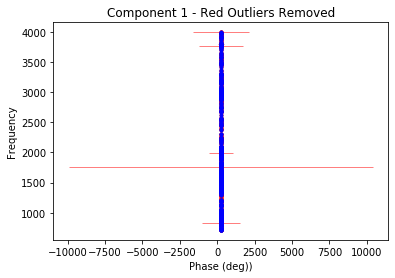

In [97]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp1, frequency_comp1, comp1_err=graphing_comp(fit_components,1)
#Plot points
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='red', label='data')
py.title('Component 1 - Red Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
#Remove outliers which are greater than 'threshold' number of std away from the mean
frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err,2)
#Plot outlier removed points"
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='blue',label='data')

In [98]:
#Fit the thorsett model to the component position
y_range=list(range(700,4040))

#Fit a powerlaw to component position
comp1_paramspl,comp1_covpl=curve_fit(powerlaw,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
comp1_fit_errorpl=np.sqrt(np.diag(comp1_covpl))
comp1_fitpl = powerlaw(y_range, *comp1_paramspl)
comp1_fitpl2 = powerlaw(frequency_comp1, *comp1_paramspl)

#Fit a linear 
comp1_paramslin,comp1_covlin=curve_fit(linear,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
comp1_fit_errorlin=np.sqrt(np.diag(comp1_covlin))
comp1_fitlin = linear(y_range, *comp1_paramslin)
comp1_fitlin2 = linear(frequency_comp1, *comp1_paramslin)

#Residuals
comp1_resid_lin = phase_comp1 - comp1_fitlin2

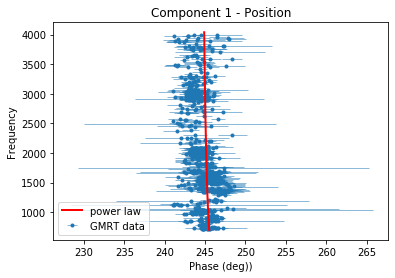

In [99]:
#Graph points with the fit ontop
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='GMRT data', zorder=0)
py.plot(comp1_fitpl, y_range,color='red',lw=2, label='power law', zorder=1)
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
py.legend(loc='lower left')

In [100]:
print(f'The power law equation of fit for this pulse is: \t Phase = {comp1_paramspl[0]:.3f} \u03BD^{comp1_paramspl[1]:.3f}')
print(f'The errors are {comp1_fit_errorpl[0]}, {comp1_fit_errorpl[1]}')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp1_paramslin[0]:.6f} \u03BD +{comp1_paramslin[1]:.3f}')
print(f'The errors are {comp1_fit_errorlin[0]}, {comp1_fit_errorlin[1]}')

The power law equation of fit for this pulse is: 	 Phase = 247.813 ν^-0.001
The errors are 0.7206931052584593, 0.00038850353135657235
The power law equation of fit for this pulse is: 	 Phase = -0.000267 ν +245.688
The errors are 5.8217116779835986e-05, 0.11832426117578936


In [101]:
print('The chi squared reduced value is', chsq_err(phase_comp1, comp1_fitpl2, comp1_err)/(len(phase_comp1)-2))

The chi squared reduced value is 9.271212836931538


### Component 2

<ErrorbarContainer object of 3 artists>

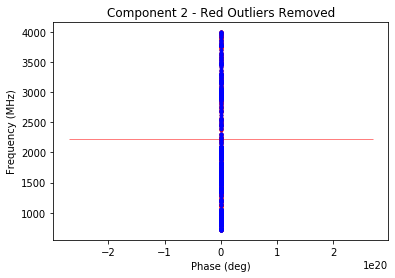

In [102]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp2, frequency_comp2, comp2_err=graphing_comp(fit_components,2)
#Plot points
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, color='red', label='data')
py.title('Component 2 - Red Outliers Removed')
py.xlabel('Phase (deg)')
py.ylabel('Frequency (MHz)')

#Remove outliers which are greater than 'threshold' number of std away from the mean
frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err,2)
#Plot outlier removed points
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, color='blue',label='data')

In [103]:
#Temporary for viewing
#print(comp2_err)
#ind=comp2_err.index(0)
#del comp2_err[ind]
#del phase_comp2[ind]
#del frequency_comp2[ind]

In [104]:
#Fit a powerlaw to the component position
comp2_paramspl,comp2_covpl=curve_fit(powerlaw,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
comp2_fit_errorpl=np.sqrt(np.diag(comp2_covpl))
comp2_fitpl = powerlaw(y_range, *comp2_paramspl)
comp2_fitpl2 = powerlaw(frequency_comp2, *comp2_paramspl)

#Fit a linear 
comp2_paramslin,comp2_covlin=curve_fit(linear,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
comp2_fit_errorlin=np.sqrt(np.diag(comp2_covlin))
comp2_fitlin = linear(y_range, *comp2_paramslin)
comp2_fitlin2 = linear(frequency_comp2, *comp2_paramslin)

#Residuals
comp2_resid_lin = phase_comp2 - comp2_fitlin2

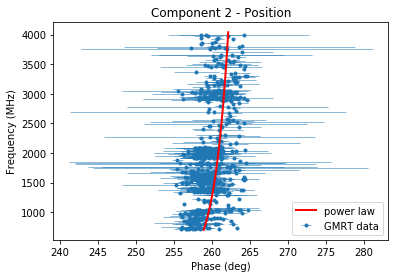

In [105]:
#Graph points with the fit ontop
py.errorbar( phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='GMRT data', zorder=0)
py.plot(comp2_fitpl,y_range, color='red',lw=2, label='power law', zorder=1)
py.title('Component 2 - Position')
py.xlabel('Phase (deg)')
py.ylabel('Frequency (MHz)')
py.legend(loc='lower right')

In [106]:
print(f'The power law equation of fit for this pulse is: \t Phase = {comp2_paramspl[0]:.3f} \u03BD^{comp2_paramspl[1]:.3f}')
print(f'The errors are {comp2_fit_errorpl[0]}, {comp2_fit_errorpl[1]}')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp2_paramslin[0]:.5f} \u03BD +{comp2_paramslin[1]:.3f}')
print(f'The errors are {comp2_fit_errorlin[0]}, {comp2_fit_errorlin[1]}')

The power law equation of fit for this pulse is: 	 Phase = 247.169 ν^0.007
The errors are 0.9957050223054371, 0.0005236976960918295
The power law equation of fit for this pulse is: 	 Phase = 0.00085 ν +258.951
The errors are 6.877252740227947e-05, 0.17685745187548554


In [107]:
print('The chi squared reduced value is',chsq_err(phase_comp2, comp2_fitpl2, comp2_err)/(len(phase_comp2)-2))

The chi squared reduced value is 20.016329645732114


# Both Component Movements

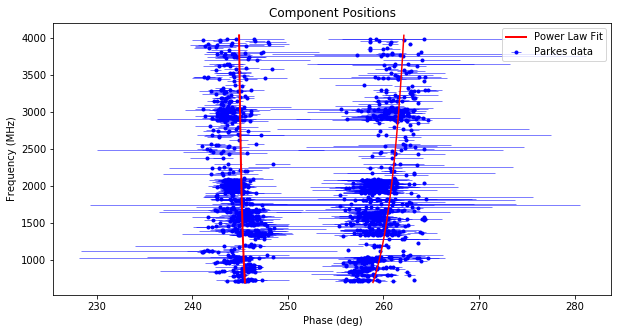

In [108]:
py.figure(figsize=(10,5))
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, color='blue', fmt='.', lw=0.5, label='Parkes data', zorder=0)
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, color='blue', fmt='.', lw=0.5, zorder=0)
py.plot(comp1_fitpl,y_range, color='red',lw=2, label='Power Law Fit', zorder=1)
py.plot(comp2_fitpl,y_range, color='red', zorder=1)
py.title('Component Positions')
py.xlabel('Phase (deg)')
py.ylabel('Frequency (MHz)')
py.legend()

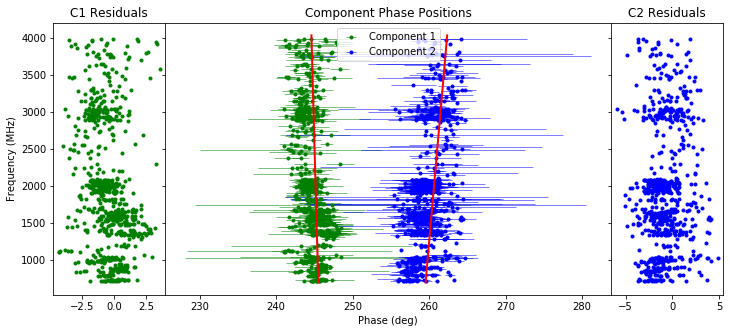

In [109]:
fig = py.figure(figsize=(12, 5))
grid = py.GridSpec(1, 6, hspace=0, wspace=0)
resid_1 = fig.add_subplot(grid[0, 0])
py.ylabel('Frequency (MHz)')
main_ax = fig.add_subplot(grid[0, 1:5], sharey=resid_1)
py.xlabel('Phase (deg)')
resid_2 = fig.add_subplot(grid[0, 5], sharey=resid_1)

resid_1.plot(comp1_resid_lin, frequency_comp1, '.', color='g')
main_ax.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, color='green', fmt='.', lw=0.5, label='Component 1', zorder=0)
main_ax.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, color='blue', fmt='.', lw=0.5, label='Component 2', zorder=0)
main_ax.plot(comp1_fitlin,y_range, color='red',lw=2, zorder=1)
main_ax.plot(comp2_fitlin,y_range, color='red',lw=2, zorder=1)
resid_2.plot(comp2_resid_lin, frequency_comp2, '.', color='b')

resid_1.set_title('C1 Residuals')
resid_2.set_title('C2 Residuals')
main_ax.set_title('Component Phase Positions')

main_ax.legend(loc='upper center')
resid_1.label_outer()
main_ax.label_outer()
resid_2.label_outer()


# Fitting Power Laws to Separation 

## Just Parkes

In [110]:
#Gain component separation values
component_sep, sep_error = separation_singleprofile(fit_components)

comp_sep=[]
frequency_forsep=[]

#Put them into arrays for graphing
for i in range(0,len(component_sep)):
    comp_sep.append(component_sep[i][1])
    frequency_forsep.append(component_sep[i][0])

Text(0.5, 1.0, 'Component Separation - Red Outliers Removed')

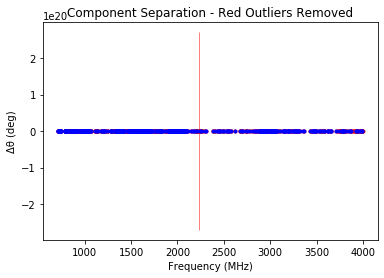

In [111]:
#Plot points
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='red', fmt='.', lw=0.5, label='data')
py.xlabel('Frequency (MHz)')
py.ylabel('\u0394\u03B8 (deg)')

#Remove outliers
frequency_forsep, comp_sep, sep_error = detect_outlier(frequency_forsep, comp_sep, sep_error, 2.5)

#Plot points with outliers removed
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='blue', fmt='.', lw=0.5, label='data')
py.title('Component Separation - Red Outliers Removed')

In [112]:
#Create a thorsett fit
expect=(703,0.5,10)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
separation_fit=thorsett(frequency_forsep,*sep_params)

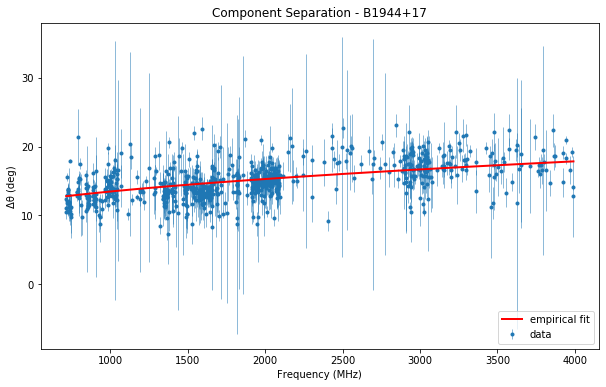

In [113]:
#Plot the thorsett fit
py.figure(figsize=(10, 6))
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.plot(frequency_forsep,separation_fit, color='red',lw=2,label='empirical fit',zorder=2)
py.title('Component Separation - B1944+17')
py.xlabel('Frequency (MHz)')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower right')


In [114]:
#chi, p = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
#print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')
print('The chi squared reduced value is',chsq_err(comp_sep, separation_fit, sep_error)/(len(comp_sep)-2))

The equation of fit for this pulsar is: 	 Δθ = 0.139 ν^0.500 + 9.093 

The errors are 0.297, 0.227, 2.537 
Units for Δθ is degrees and ν is MHz
The chi squared reduced value is 3.7411820360204877


## Parkes and EPN

In [115]:
#Gain component separation values
ant_sep, ant_error = separation_singleprofile(ant_components)
gl_sep, gl_error = separation_singleprofile(gl_components)
j_sep, j_error = separation_singleprofile(j_components)
wc_sep, wc_error = separation_singleprofile(wc_components)
sgg_sep, sgg_error = separation_singleprofile(sgg_components)

epn_sep = [ant_sep, gl_sep, j_sep, wc_sep, sgg_sep]
epn_error = [ant_error, gl_error, j_error, wc_error, sgg_error]

epn_seps=[]
frequency_epn=[]
epn_errors=[]

#Put them into arrays for graphing
for k,epn in enumerate(epn_sep):
    for i in range(0,len(epn)):
        comp_sep.append(epn[i][1])
        frequency_forsep.append(epn[i][0])
        sep_error.append(epn_error[k][i])

        epn_seps.append(epn[i][1])
        frequency_epn.append(epn[i][0])
        epn_errors.append(epn_error[k][i])

In [59]:
epn_sep

[[component_separation(frequency=400, separation=13.121290455683464),
  component_separation(frequency=800, separation=14.65835504125883),
  component_separation(frequency=1330, separation=15.567699695482787),
  component_separation(frequency=1640, separation=16.31294112478261)],
 [component_separation(frequency=410, separation=11.10132391690243),
  component_separation(frequency=610, separation=12.823880712970833),
  component_separation(frequency=925, separation=13.771958731232957),
  component_separation(frequency=1408, separation=14.73817595847595)],
 [component_separation(frequency=673.9, separation=13.617310219134481)],
 [component_separation(frequency=1418, separation=11.431643163462525)],
 [component_separation(frequency=1420, separation=12.120002525867932),
  component_separation(frequency=4750, separation=20.304352220871735)]]

In [60]:
#Create a thorsett fit
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))

freq_fit = np.linspace(300, 4900, 460)
separation_fit=thorsett(freq_fit,*sep_params)

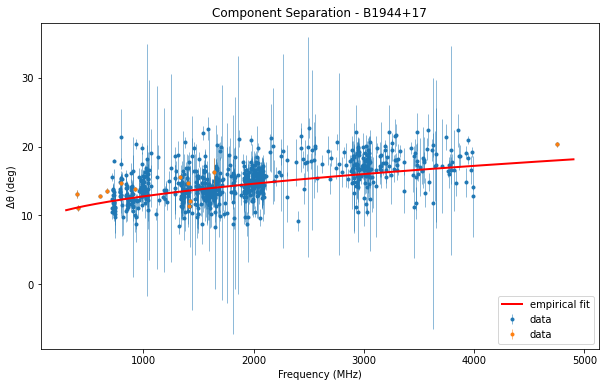

In [61]:
#Plot the thorsett fit
py.figure(figsize=(10, 6))
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.errorbar(frequency_epn, epn_seps, yerr=epn_errors, fmt='.', lw=0.5, label='data',zorder=2)
py.plot(freq_fit,separation_fit, color='red',lw=2,label='empirical fit',zorder=3)
py.title('Component Separation - B1944+17')
py.xlabel('Frequency (MHz)')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower right')

# Change in Intensity over Frequency for GMRT

## Fit Peaks (fit_components)

Text(0, 0.5, 'Intensity')

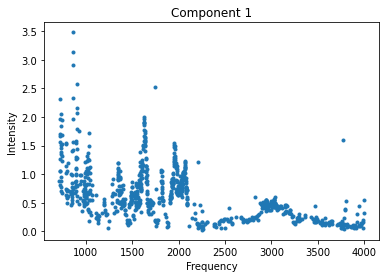

In [62]:
#Find intensity of components at each frequency and graph
intensity_comp1=[]
frequency_comp1=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp1.append(fit_components[i][1][1])
    frequency_comp1.append(fit_components[i][0])
    
py.plot(frequency_comp1,intensity_comp1, '.')
py.title('Component 1')
py.xlabel('Frequency')
py.ylabel('Intensity')

Text(0, 0.5, 'Intensity')

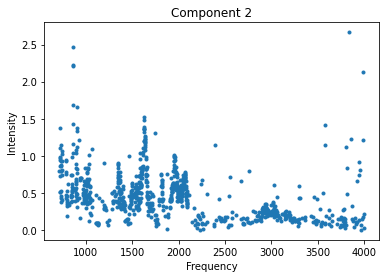

In [63]:
#Find intensity of components at each frequency and graph
intensity_comp2=[]
frequency_comp2=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp2.append(fit_components[i][2][1])
    frequency_comp2.append(fit_components[i][0])

py.plot(frequency_comp2,intensity_comp2, '.')
py.title('Component 2')
py.xlabel('Frequency')
py.ylabel('Intensity')

In [64]:
int_ratio=np.array(intensity_comp1)/np.array(intensity_comp2)

Text(0, 0.5, 'Intensity Ratio')

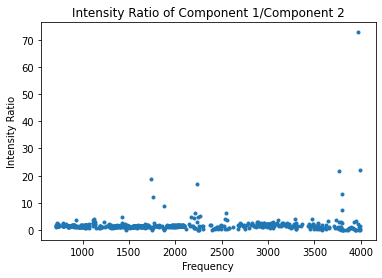

In [65]:
py.plot(frequency_comp2,int_ratio, '.')
py.title('Intensity Ratio of Component 1/Component 2')
py.xlabel('Frequency')
py.ylabel('Intensity Ratio')